<a href="https://colab.research.google.com/github/Yassine-Sebri/Advanced-Data-Science-Specializaton-Capstone/blob/master/Feature%20Engineering%20and%20Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
# Essentials
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter('ignore')

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Dropout

# Misc
from collections import Counter
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup             
import re
import random
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
nltk.download('all')

In [3]:
# Reading data
data = pd.read_csv("/content/drive/My Drive/IBM Advanced Data Science Capstone/IMDB Dataset.csv")
data.shape

(50000, 2)

##Preprocessing

In [4]:
# Label encoding
label_encoder = preprocessing.LabelEncoder()
data['sentiment'] = label_encoder.fit_transform(data['sentiment'])

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [5]:
def preprocessing(raw_review):
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review).get_text() 

    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 

    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             

    # 4. Converting to set for better time complexity
    stops = set(stopwords.words("english"))                  

    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   

    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words))  
 
index = random.randrange(50000)

print("Original review: {}".format(data.review.values[index]))
print("Preprocessed : {}".format(preprocessing(data.review.values[index])))

Original review: For a made-for-TV "horror" movie the movie started off very interesting. I was really intrigued by the story and the mystery of the film. But the ending was a total dissappointment. The movie was going along fast-paced and was building up to, it seemed like anyway, to a very climatic end. But guess what there is no end. The movie is just over and after almost one-and-a-half hours the audience is just left wondering what happened. Why were all the unanswered questions in the film left unanswered. There was no explanation at all about any of the key points in the plot. This film is like watching a murder mystery and then never finding out who did it. Very dissappointed. This film looks like the producers just ran out of money and never completed the film. A real BOMB!
Preprocessed : made tv horror movie movie started interesting really intrigued story mystery film ending total dissappointment movie going along fast paced building seemed like anyway climatic end guess end

In [0]:
preprocessed_data = data
preprocessed_data['review'] = preprocessed_data['review'].apply(preprocessing)

##Feature Engineering

In [7]:
NGRAM_RANGE = (1, 2)
TOP_K = 20000
TOKEN_MODE = 'word'
MIN_DOC_FREQ = 2

def ngram_vectorize(texts, labels):
    kwargs = {
        'ngram_range' : NGRAM_RANGE,
        'dtype' : 'int32',
        'strip_accents' : 'unicode',
        'decode_error' : 'replace',
        'analyzer' : TOKEN_MODE,
        'min_df' : MIN_DOC_FREQ,
    }
    # Learn Vocab from train texts and vectorize train and val sets
    tfidf_vectorizer = TfidfVectorizer(**kwargs)
    transformed_texts = tfidf_vectorizer.fit_transform(texts)
    
    # Select best k features, with feature importance measured by f_classif
    # Set k as 20000 or (if number of ngrams is less) number of ngrams   
    selector = SelectKBest(f_classif, k=min(TOP_K, transformed_texts.shape[1]))
    selector.fit(transformed_texts, labels)
    transformed_texts = selector.transform(transformed_texts).astype('float32')
    return transformed_texts
# Vectorize the data
vect_data = ngram_vectorize(preprocessed_data['review'], preprocessed_data['sentiment'])
vect_data.shape

(50000, 20000)

In [8]:
tfidf = TfidfVectorizer()
tr_texts = tfidf.fit_transform(preprocessed_data['review'])
tr_texts.shape

(50000, 101227)

##Modeling

In [9]:
# Split data to target y and features X
X = vect_data.toarray()
y = (np.array(data['sentiment']))

# Here we split data to training and testing parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train dataset shape: {0}, \nTest dataset shape: {1}".format(X_train.shape, X_test.shape))

Train dataset shape: (40000, 20000), 
Test dataset shape: (10000, 20000)


###Classic Models

In [0]:
# Naive Bayes
clf = MultinomialNB()
clf.fit(X_train, y_train)
nb_accuracy = clf.score(X_test, y_test)

In [0]:
# Random Forest
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X_train, y_train)
rf_accuracy = rf.score(X_test, y_test)

###Deep Learning

In [12]:
input_shape = X_train.shape[1:]

model = Sequential()
model.add(Dropout(rate=0.2, input_shape=input_shape))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1280064   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,284,289
Trainable params: 1,284,289
Non-trainable params: 0
______________________________________________

In [0]:
LEARNING_RATE = 1e-3

loss = 'binary_crossentropy'

optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

In [14]:
EPOCHS = 5
BATCH_SIZE = 64

# Train and validate model
# To start training, call the model.fit method—the model is "fit" to the training data.
# Note that fit() will return a History object which we can use to plot training vs. validation accuracy and loss.
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), verbose=1, 
                    batch_size=BATCH_SIZE)

Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 4s 103us/sample - loss: 0.3266 - acc: 0.8704 - val_loss: 0.1979 - val_acc: 0.9228
Epoch 2/5
40000/40000 [==============================] - 3s 84us/sample - loss: 0.1844 - acc: 0.9300 - val_loss: 0.1851 - val_acc: 0.9261
Epoch 3/5
40000/40000 [==============================] - 3s 84us/sample - loss: 0.1472 - acc: 0.9422 - val_loss: 0.1820 - val_acc: 0.9281
Epoch 4/5
40000/40000 [==============================] - 3s 82us/sample - loss: 0.1236 - acc: 0.9531 - val_loss: 0.1938 - val_acc: 0.9263
Epoch 5/5
40000/40000 [==============================] - 3s 82us/sample - loss: 0.1020 - acc: 0.9620 - val_loss: 0.2035 - val_acc: 0.9272


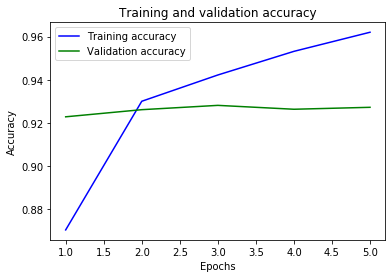

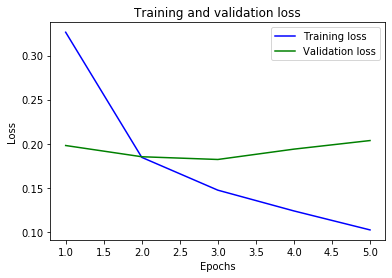

In [15]:
# Let's plot training and validation accuracy as well as loss.
def plot_history(history):
    accuracy = history.history['acc']
    val_accuracy = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1,len(accuracy) + 1)
    
    # Plot accuracy  
    plt.figure(1)
    plt.plot(epochs, accuracy, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.figure(2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history)

###Model Comparison

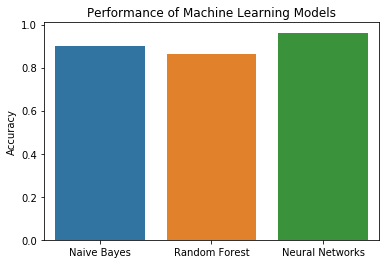

In [16]:
y_pos = np.arange(3)
sns.barplot(y_pos, [nb_accuracy, rf_accuracy, max(history.history['acc'])]);
plt.title("Performance of Machine Learning Models");
plt.ylabel("Accuracy");
plt.xticks(y_pos, ("Naive Bayes", "Random Forest", "Neural Networks"));